In [1]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
year = 20
donors_csv = f"./output/donors_recip_agg_pred_lastname_trunc.csv"

In [3]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,recip_id,name_new,realcode,gender,occupation,city,state,total_donated,donation_count,...,seat,ran_general,type,cmte_id,pac_short,recip_id_pac,cand_id,recip_is_pac,dem_ratio,level
0,1,C60000015,republican national committee republican natio...,B1500,,NaN,WASHINGTON,DC,77820848.0,4793,...,NaN,NaN,NaN,C60000015,RNC/Repub National State Elections Cmte,C60000015,NaN,True,NaN,PAC
1,,N00000802,,Z9000,,NaN,NaN,,72634500.0,75,...,PRES,,O,NaN,NaN,NaN,NaN,False,-0.420059,President
2,1,C60000262,dnc general fund dnc general fund,K1000,,NaN,WASHINGTON,DC,40192970.0,2247,...,NaN,NaN,NaN,C60000262,DNC/Non-Federal Corporate,C60000262,NaN,True,NaN,PAC
3,1,C60000205,at&t at&t,B1500,,NaN,WASHINGTON,DC,32889365.0,9112,...,NaN,NaN,NaN,C60000205,NRCC/Non-Federal,C60000205,NaN,True,NaN,PAC
4,1,C60000148,at&t at&t,H4300,,NaN,WASHINGTON,DC,30116512.0,2572,...,NaN,NaN,NaN,C60000148,NRSC/Non-Federal,C60000148,NaN,True,NaN,PAC
5,1,C60000080,dccc nonfederal receipts-c dccc nonfederal rec...,Z9100,,NaN,WASHINGTON,DC,22149421.0,545,...,NaN,NaN,NaN,C60000080,DCCC/Non-Federal Account 1,C60000080,NaN,True,NaN,PAC
6,1,C60000619,bacardi-martini usa inc bacardi-martini usa inc,K1000,,NaN,WASHINGTON,DC,20752086.0,963,...,NaN,NaN,NaN,C60000619,DSCC/Non-Federal Corporate,C60000619,NaN,True,NaN,PAC
7,1,C60001450,mci worldcom mci worldcom,K1000,,NaN,WASHINGTON,DC,16237657.0,1559,...,NaN,NaN,NaN,C60001450,DCCC/Non-Federal Account 1,C60001450,NaN,True,NaN,PAC
8,1,C60000247,i b e w educational committee i b e w educatio...,LB100,,NaN,WASHINGTON,DC,13487450.0,217,...,NaN,NaN,NaN,C60000247,DNC/Non-Federal General,C60000247,NaN,True,NaN,PAC
9,1,C60000288,dccc nonfederal receipts-i dccc nonfederal rec...,Z9100,,NaN,WASHINGTON,DC,9651243.0,48,...,NaN,NaN,NaN,C60000288,DCCC/Non-Federal Account 5,C60000288,NaN,True,NaN,PAC


In [4]:
donors["level"].value_counts()

level
PAC          14768809
House        13329955
President     4432438
Unknown         18200
Name: count, dtype: int64

In [5]:
donors["party"].value_counts()

party
D    10233961
R     8405383
I      310080
3       39094
L       17500
U         137
Name: count, dtype: int64

In [6]:
donors[["recip_id", "name_y"]].value_counts()

recip_id   name_y                               
C00003418  Republican National Cmte                 1593676
C00694323  WinRed                                    994887
N00001669  Joe Biden (D)                             863872
N00023864  Donald Trump (R)                          819862
C00010603  DNC Services Corp                         809651
                                                     ...   
C00714139  Dump the Chump                                 1
C00714113  Big Tree PAC                                   1
C00714097  Blake Harrison Victory Fund                    1
C00713834  Outraise PAC                                   1
C00782490  Americans for Conservative Government          1
Name: count, Length: 34047, dtype: int64

In [7]:
donors["seat"].value_counts()

seat
PRES    4432438
VTS1     493932
GAS2     401963
TXS2     256932
MAS1     241500
         ...   
CA00          5
TX00          5
SC00          3
ASAS          2
              1
Name: count, Length: 578, dtype: int64

In [8]:
donors[donors["indian"] == True]["seat"].value_counts()

seat
PRES    47389
IL08     6780
VTS1     6062
NYS1     4376
GAS2     3360
        ...  
PA20        3
OK06        1
OH19        1
NY31        1
MI16        1
Name: count, Length: 571, dtype: int64

In [9]:
donors[donors["indian"] == True].sort_values(by="total_donated", ascending=False).head(10)[["contrib_id", "recip_id", "name_new", "realcode", "gender", "occupation", "city", "state", "total_donated", "name_y", "party", "seat", "type"]]

,contrib_id,recip_id,name_new,realcode,gender,occupation,city,state,total_donated,name_y,party,seat,type
16285911,h3003465387,N00041034,shiva dr ayyadurai,Z9000,M,CHAIRMAN & CEO,CAMBRIDGE,MA,4817653.0,Shiva Ayyadurai (I),I,MAS1,C
26570010,U0000004761,C00473918,nishad singh,F2800,M,DIRECTOR OF ENGINEERING,"NEW PROVIDENCE, BAHAMAS",NaN,2250000.0,Women Vote!,NaN,NaN,NaN
26570051,U0000004761,C00484642,nishad singh,F2800,M,DIRECTOR OF ENGINEERING,LOS ALTOS HILLS,CA,2000000.0,Senate Majority PAC,D,NaN,NaN
12402789,U0000003169,C00495861,philip r munger,F7000,M,INVESTOR,NEW YORK,NY,1850000.0,Priorities USA Action,NaN,NaN,NaN
26570199,U0000004761,C00476978,nishad singh,F2800,M,DIRECTOR OF ENGINEERING,NASSAU,NaN,1100000.0,LGBTQ Victory Fund,NaN,NaN,NaN
19433829,h3003465387,N00041034,shiva ayyadurai,Z9000,U,CHAIRMAN & CEO,BELMONT,MA,1044900.0,Shiva Ayyadurai (R),R,MAS2,C
26570232,U00000047351,C00486845,reuben munger,F2500,M,MANAGING PARTNER,BOULDER,CO,1002000.0,LCV Victory Fund,NaN,NaN,NaN
19433886,U00000033011,C00492140,vinod khosla,F2500,M,FOUNDER,SAN JOSE,CA,1000000.0,American Bridge 21st Century,NaN,NaN,NaN
19433863,U0000004761,C00669259,nishad singh,F2800,M,DIRECTOR OF ENGINEERING,SAN FRANCISCO,CA,1000000.0,Future Forward USA,D,NaN,NaN
12402885,U0000004554,C00582841,vivek garipalli,H2100,M,EXECUTIVE,WILMINGTON,DE,1000000.0,Coalition For Progress,NaN,NaN,NaN


In [10]:
population = pd.read_csv("./data/aapi_population.csv")
population.head(10)

,Year,Name,Code,Indian Pop,Census Pop,Share
0,2014,Alabama,AL,11754,4841799,0.242761
1,2014,Alaska,AK,0,736283,0.000000
2,2014,Arizona,AZ,39764,6730413,0.590811
3,2014,Arkansas,AR,8035,2967392,0.270776
4,2014,California,CA,607297,38596972,1.573432
5,2014,Colorado,CO,20342,5350101,0.380217
6,2014,Connecticut,CT,49204,3594524,1.368860
7,2014,Delaware,DE,13349,932487,1.431548
8,2014,District of Columbia,DC,136461,662328,20.603236
9,2014,Florida,FL,130382,19845911,0.656972


In [11]:
# donors["dollar_lean"] = donors.progress_apply(lambda x: x["total_donated"] * -1 if x["party"] == "R" else x["total_donated"] * 0 if x["party"] not in ["D", "R"] else x["total_donated"], axis=1)
donors['dollar_lean'] = np.select([donors['party'] == 'R', ~donors['party'].isin(['D', 'R'])], [donors['total_donated'] * -1, 0], default=donors['total_donated'])

state_stats = (
    donors[donors["cycle"] == 2000 + int(year)].groupby(["state"])
    .agg(
        total_donations=("total_donated", "sum"),
        lean_other=("dem_ratio", lambda x: x[donors.loc[x.index, "indian"] == False].mean()),
        lean_indian=("dem_ratio", lambda x: x[donors.loc[x.index, "indian"] == True].mean()),
        dollar_lean_other=("dollar_lean", lambda x: x[donors.loc[x.index, "indian"] == False].sum()),
        dollar_lean_indian=("dollar_lean", lambda x: x[donors.loc[x.index, "indian"] == True].sum()),
        sum_other=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == False].sum()),
        sum_indian=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == True].sum()),
        count_other=("indian", lambda x: (x == False).sum()),
        count_indian=("indian", lambda x: (x == True).sum())
    )
    .sort_values("total_donations", ascending=False)
    .reset_index()
)

state_stats["dollar_lean_other"] = state_stats["dollar_lean_other"] / state_stats["sum_other"]
state_stats["dollar_lean_indian"] = state_stats["dollar_lean_indian"] / state_stats["sum_indian"]
state_stats.head(10)

,state,total_donations,lean_other,lean_indian,dollar_lean_other,dollar_lean_indian,sum_other,sum_indian,count_other,count_indian
0,CA,2.302541e+09,0.409152,0.670178,0.314477,0.322459,2.267715e+09,34826034.0,1168713,18470
1,NY,2.123858e+09,0.576562,0.664727,0.612629,0.299299,2.109585e+09,14273570.0,512890,7822
2,TX,8.459536e+08,-0.237009,0.406213,-0.227482,0.197434,8.359196e+08,10034030.0,535458,6674
3,DC,7.547413e+08,0.761868,0.844831,0.315670,0.412078,7.529256e+08,1815732.0,103402,1373
4,FL,6.972270e+08,-0.202243,0.141982,-0.202440,-0.053810,6.890635e+08,8163436.0,453779,3778
5,VA,4.690193e+08,0.196320,0.671245,-0.037003,0.361972,4.644406e+08,4578637.0,235364,3053
6,IL,4.109985e+08,0.356580,0.566609,0.028298,0.290049,4.051769e+08,5821547.0,242625,3882
7,MA,3.618389e+08,0.712083,0.837576,0.362654,0.101941,3.557552e+08,6083660.0,237837,2733
8,WA,2.522107e+08,0.476707,0.787386,0.184793,0.312144,2.483139e+08,3896806.0,244725,2455
9,PA,2.519656e+08,0.219151,0.495522,0.044129,0.193885,2.493941e+08,2571504.0,237303,2363


In [13]:
# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
state_df = gdf.merge(state_stats, on="state", how="left")
state_df = state_df.merge(population[population["Year"] == 2000 + year], left_on="state", right_on="Code", how="left")
state_df.iloc[:2]

,iso_3166_2,name,geometry,state,total_donations,lean_other,lean_indian,dollar_lean_other,dollar_lean_indian,sum_other,sum_indian,count_other,count_indian,Year,Name,Code,Indian Pop,Census Pop,Share
0,US-MN,Minnesota,"POLYGON ((-89.95766 47.28691, -90.13175 47.292...",MN,121035111.0,0.292489,0.545563,0.081824,0.171450,120406625.0,628486.0,119385,735,2020,Minnesota,MN,45092,5710735,0.789601
1,US-MT,Montana,"POLYGON ((-116.04823 49.00037, -113.0595 49.00...",MT,31470444.0,-0.058101,-0.170732,-0.083783,-0.620498,31332234.0,138210.0,29170,61,2020,Montana,MT,756,1087230,0.069535


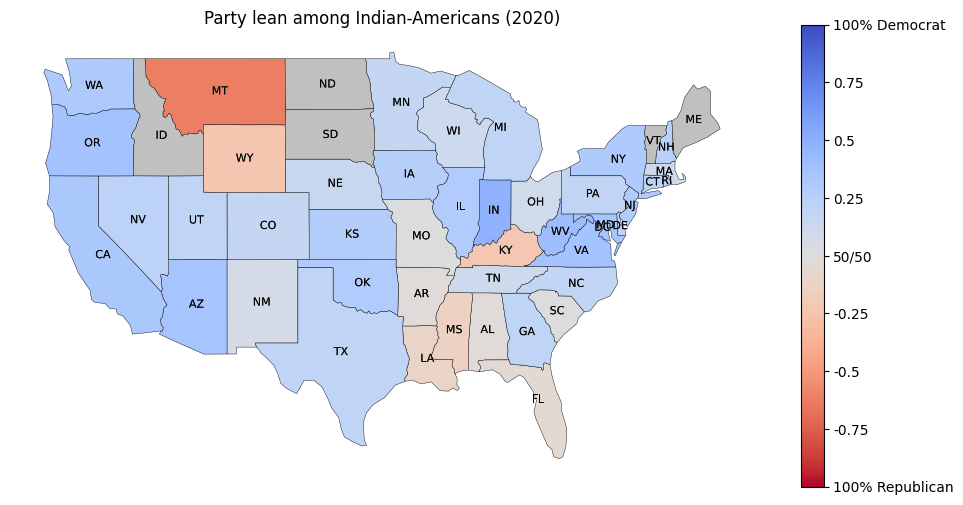

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df = state_df.copy()
copy_df.loc[copy_df['sum_indian'] < 100000, 'dollar_lean_indian'] = np.nan

map = copy_df.plot(
    column="dollar_lean_indian",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "silver"},
    vmin=-1,
    vmax=1
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = ["100% Democrat" if tick == 1 
               else "100% Republican" if tick == -1 
               else "50/50" if tick == 0
               else tick for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among Indian-Americans (20{year})')
ax.axis("off")
plt.show()

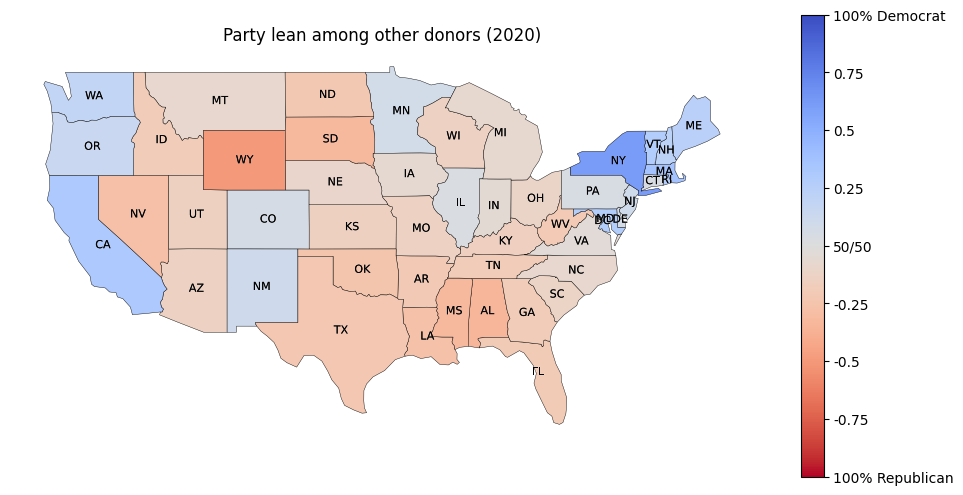

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

map = state_df.plot(
    column="dollar_lean_other",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "silver"},
    vmin=-1,
    vmax=1
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = ["100% Democrat" if tick == 1 
               else "100% Republican" if tick == -1 
               else "50/50" if tick == 0
               else tick for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among other donors (20{year})')
ax.axis("off")
plt.show()

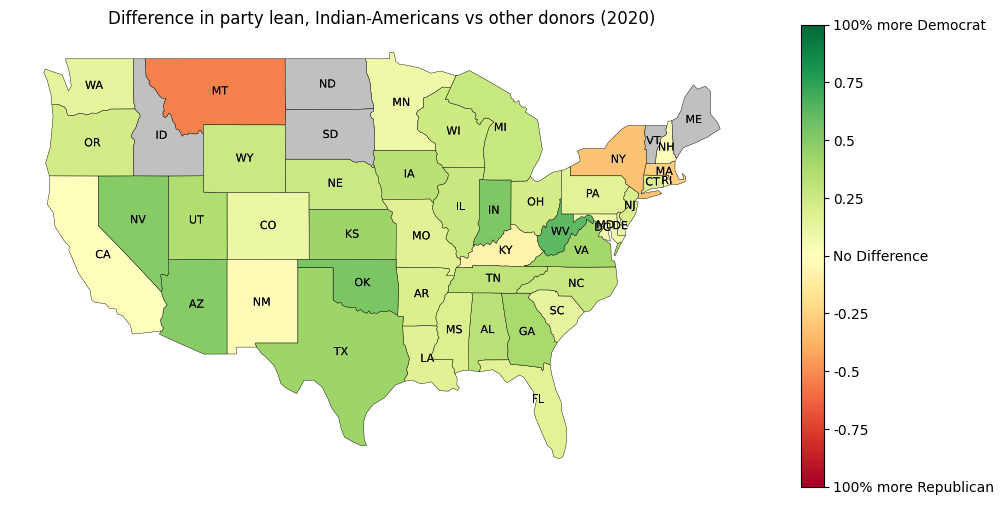

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df["dollar_lean_diff"] = copy_df["dollar_lean_indian"] - copy_df["dollar_lean_other"] 

map = copy_df.plot(
    column="dollar_lean_diff",
    cmap="RdYlGn",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "silver"},
    vmin=-1,
    vmax=1
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = ["100% more Democrat" if tick == 1 
               else "100% more Republican" if tick == -1 
               else "No Difference" if tick == 0
               else tick for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Difference in party lean, Indian-Americans vs other donors (20{year})')
ax.axis("off")
plt.show()

In [17]:
donors['dollar_lean'] = np.select([donors['party'] == 'R', ~donors['party'].isin(['D', 'R'])], [donors['total_donated'] * -1, 0], default=donors['total_donated'])

state_pac_stats = (
    donors[donors["cycle"] == 2000 + int(year)].groupby(["state", "level"])
    .agg(
        total_donations=("total_donated", "sum"),
        lean_other=("dem_ratio", lambda x: x[donors.loc[x.index, "indian"] == False].mean()),
        lean_indian=("dem_ratio", lambda x: x[donors.loc[x.index, "indian"] == True].mean()),
        dollar_lean_other=("dollar_lean", lambda x: x[donors.loc[x.index, "indian"] == False].sum()),
        dollar_lean_indian=("dollar_lean", lambda x: x[donors.loc[x.index, "indian"] == True].sum()),
        sum_other=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == False].sum()),
        sum_indian=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == True].sum()),
        count_other=("indian", lambda x: (x == False).sum()),
        count_indian=("indian", lambda x: (x == True).sum())
    )
    .sort_values("total_donations", ascending=False)
    .reset_index()
)

state_pac_stats["dollar_lean_other"] = state_pac_stats["dollar_lean_other"] / state_pac_stats["sum_other"]
state_pac_stats["dollar_lean_indian"] = state_pac_stats["dollar_lean_indian"] / state_pac_stats["sum_indian"]
state_pac_stats.head(10)

,state,level,total_donations,lean_other,lean_indian,dollar_lean_other,dollar_lean_indian,sum_other,sum_indian,count_other,count_indian
0,CA,PAC,1.197363e+09,0.239947,0.491274,0.001138,0.075831,1.175649e+09,21714073.0,530661,7101
1,NY,President,1.191140e+09,0.670154,0.713600,0.969040,0.630888,1.188995e+09,2145032.0,98826,1633
2,DC,PAC,6.731583e+08,0.713227,0.838826,0.261654,-0.026168,6.723004e+08,857902.0,39939,540
3,NY,PAC,6.730618e+08,0.420542,0.466169,-0.041576,-0.045973,6.652456e+08,7816172.0,218396,3049
4,CA,President,6.720094e+08,0.514324,0.748064,0.718082,0.693417,6.676303e+08,4379081.0,233683,4133
5,TX,PAC,5.680220e+08,-0.461459,0.072168,-0.273487,-0.175492,5.633456e+08,4676418.0,273471,2618
6,FL,PAC,4.900755e+08,-0.378775,-0.104931,-0.234720,-0.161411,4.841410e+08,5934520.0,240581,1881
7,CA,House,4.327751e+08,0.493947,0.747033,0.548044,0.749676,4.240423e+08,8732880.0,404170,7236
8,VA,PAC,3.556673e+08,0.017250,0.500731,-0.125744,0.033915,3.531871e+08,2480164.0,113036,1229
9,IL,PAC,2.877167e+08,0.129163,0.326901,-0.154525,-0.074596,2.851116e+08,2605106.0,113428,1422


In [21]:
# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
state_house_df = gdf.merge(state_pac_stats[state_pac_stats["level"] == "House"], on="state", how="left")
state_house_df = state_house_df.merge(population[population["Year"] == 2000 + year], left_on="state", right_on="Code", how="left")
state_house_df.iloc[:2]

,iso_3166_2,name,geometry,state,level,total_donations,lean_other,lean_indian,dollar_lean_other,dollar_lean_indian,sum_other,sum_indian,count_other,count_indian,Year,Name,Code,Indian Pop,Census Pop,Share
0,US-MN,Minnesota,"POLYGON ((-89.95766 47.28691, -90.13175 47.292...",MN,House,36446023.0,0.385147,0.566044,0.409778,0.516963,36257853.0,188170.0,41937,259,2020,Minnesota,MN,45092,5710735,0.789601
1,US-MT,Montana,"POLYGON ((-116.04823 49.00037, -113.0595 49.00...",MT,House,11934746.0,0.102086,0.111111,0.151431,-0.251590,11911943.0,22803.0,11936,25,2020,Montana,MT,756,1087230,0.069535


In [22]:
# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
state_pres_df = gdf.merge(state_pac_stats[state_pac_stats["level"] == "President"], on="state", how="left")
state_pres_df = state_pres_df.merge(population[population["Year"] == 2000 + year], left_on="state", right_on="Code", how="left")
state_pres_df.iloc[:2]

,iso_3166_2,name,geometry,state,level,total_donations,lean_other,lean_indian,dollar_lean_other,dollar_lean_indian,sum_other,sum_indian,count_other,count_indian,Year,Name,Code,Indian Pop,Census Pop,Share
0,US-MN,Minnesota,"POLYGON ((-89.95766 47.28691, -90.13175 47.292...",MN,President,15211124.0,0.461247,0.737799,0.245892,0.573302,15092375.0,118749.0,21461,161,2020,Minnesota,MN,45092,5710735,0.789601
1,US-MT,Montana,"POLYGON ((-116.04823 49.00037, -113.0595 49.00...",MT,President,3381295.0,0.028702,0.142857,-0.251185,-0.979520,3333052.0,48243.0,4129,7,2020,Montana,MT,756,1087230,0.069535


In [24]:
# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
state_pac_df = gdf.merge(state_pac_stats[state_pac_stats["level"] == "PAC"], on="state", how="left")
state_pac_df = state_pac_df.merge(population[population["Year"] == 2000 + year], left_on="state", right_on="Code", how="left")
state_pac_df.iloc[:2]

,iso_3166_2,name,geometry,state,level,total_donations,lean_other,lean_indian,dollar_lean_other,dollar_lean_indian,sum_other,sum_indian,count_other,count_indian,Year,Name,Code,Indian Pop,Census Pop,Share
0,US-MN,Minnesota,"POLYGON ((-89.95766 47.28691, -90.13175 47.292...",MN,PAC,69370964.0,0.038941,0.311893,-0.126238,-0.179129,69049397.0,321567.0,55979,315,2020,Minnesota,MN,45092,5710735,0.789601
1,US-MT,Montana,"POLYGON ((-116.04823 49.00037, -113.0595 49.00...",MT,PAC,16154403.0,-0.353646,-0.625000,-0.223266,-0.487866,16087239.0,67164.0,13105,29,2020,Montana,MT,756,1087230,0.069535


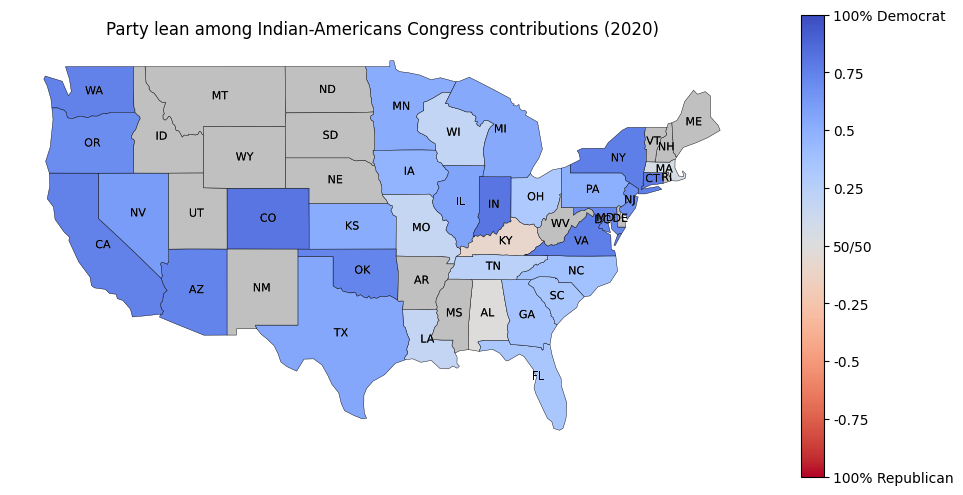

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df = state_house_df.copy()
copy_df.loc[copy_df['sum_indian'] < 100000, 'dollar_lean_indian'] = np.nan

map = copy_df.plot(
    column="dollar_lean_indian",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "silver"},
    vmin=-1,
    vmax=1
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = ["100% Democrat" if tick == 1 
               else "100% Republican" if tick == -1 
               else "50/50" if tick == 0
               else tick for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among Indian-Americans Congress contributions (20{year})')
ax.axis("off")
plt.show()

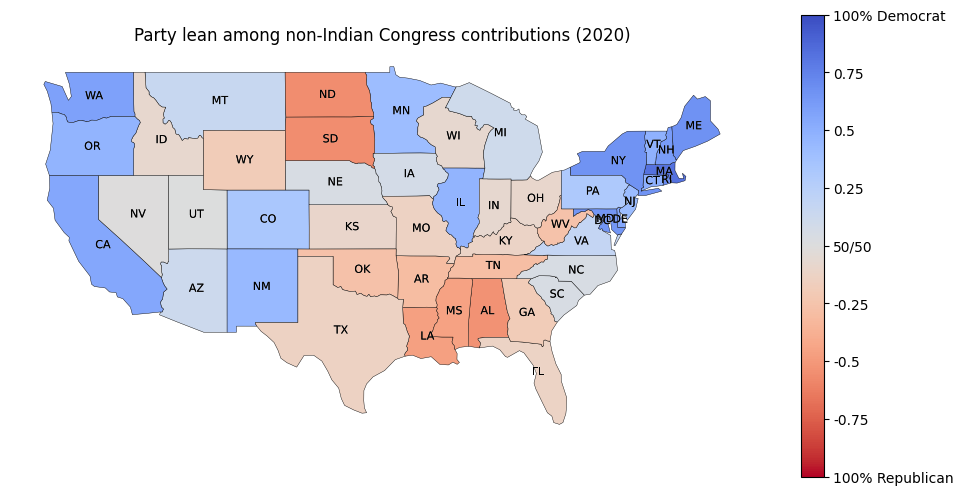

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df = state_house_df.copy()
copy_df.loc[copy_df['sum_indian'] < 100000, 'dollar_lean_indian'] = np.nan

map = copy_df.plot(
    column="dollar_lean_other",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "silver"},
    vmin=-1,
    vmax=1
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = ["100% Democrat" if tick == 1 
               else "100% Republican" if tick == -1 
               else "50/50" if tick == 0
               else tick for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among non-Indian Congress contributions (20{year})')
ax.axis("off")
plt.show()

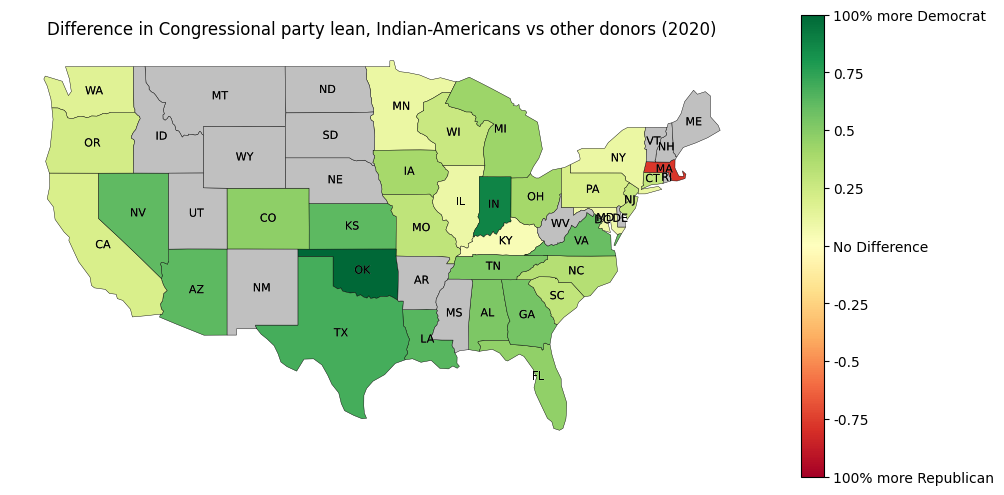

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df["dollar_lean_diff"] = copy_df["dollar_lean_indian"] - copy_df["dollar_lean_other"] 

map = copy_df.plot(
    column="dollar_lean_diff",
    cmap="RdYlGn",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "silver"},
    vmin=-1,
    vmax=1
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = ["100% more Democrat" if tick == 1 
               else "100% more Republican" if tick == -1 
               else "No Difference" if tick == 0
               else tick for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Difference in Congressional party lean, Indian-Americans vs other donors (20{year})')
ax.axis("off")
plt.show()

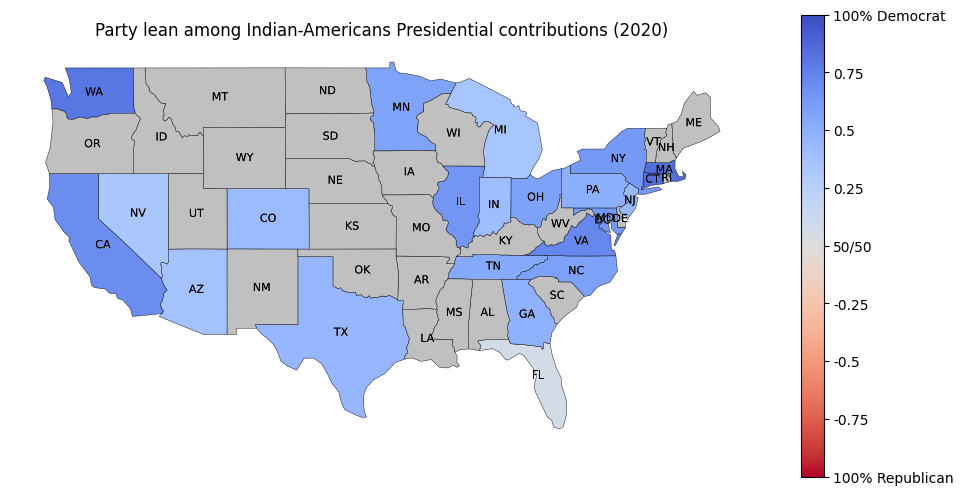

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df = state_pres_df.copy()
copy_df.loc[copy_df['sum_indian'] < 100000, 'dollar_lean_indian'] = np.nan

map = copy_df.plot(
    column="dollar_lean_indian",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "silver"},
    vmin=-1,
    vmax=1
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = ["100% Democrat" if tick == 1 
               else "100% Republican" if tick == -1 
               else "50/50" if tick == 0
               else tick for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among Indian-Americans Presidential contributions (20{year})')
ax.axis("off")
plt.show()

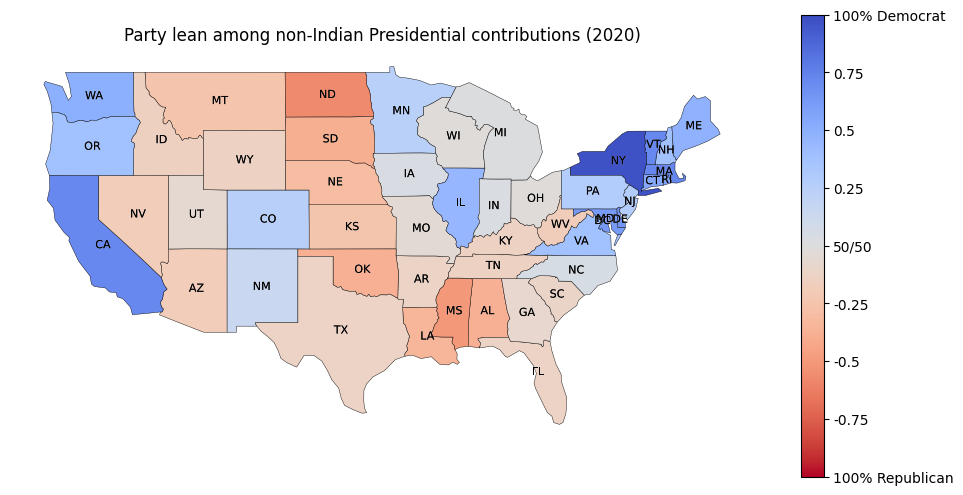

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df = state_pres_df.copy()
copy_df.loc[copy_df['sum_indian'] < 100000, 'dollar_lean_indian'] = np.nan

map = copy_df.plot(
    column="dollar_lean_other",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "silver"},
    vmin=-1,
    vmax=1
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = ["100% Democrat" if tick == 1 
               else "100% Republican" if tick == -1 
               else "50/50" if tick == 0
               else tick for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among non-Indian Presidential contributions (20{year})')
ax.axis("off")
plt.show()

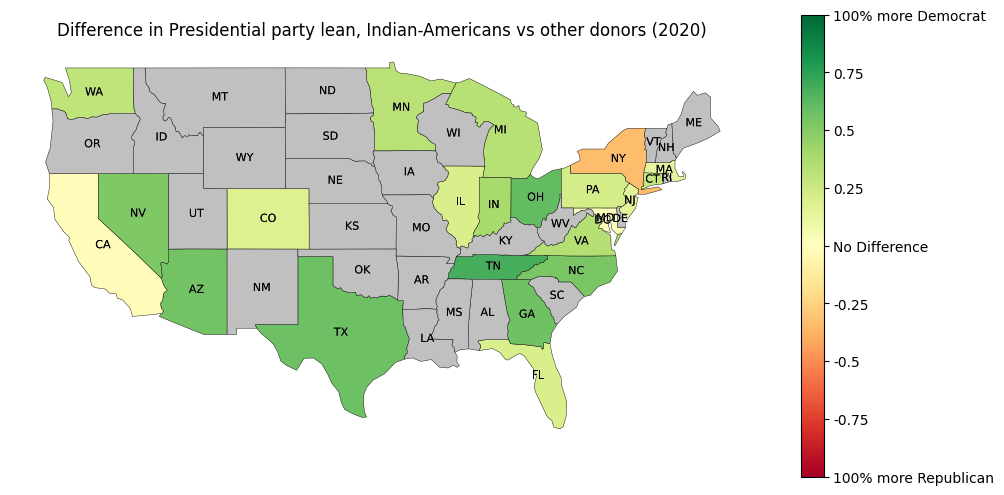

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df["dollar_lean_diff"] = copy_df["dollar_lean_indian"] - copy_df["dollar_lean_other"] 

map = copy_df.plot(
    column="dollar_lean_diff",
    cmap="RdYlGn",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "silver"},
    vmin=-1,
    vmax=1
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = ["100% more Democrat" if tick == 1 
               else "100% more Republican" if tick == -1 
               else "No Difference" if tick == 0
               else tick for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Difference in Presidential party lean, Indian-Americans vs other donors (20{year})')
ax.axis("off")
plt.show()

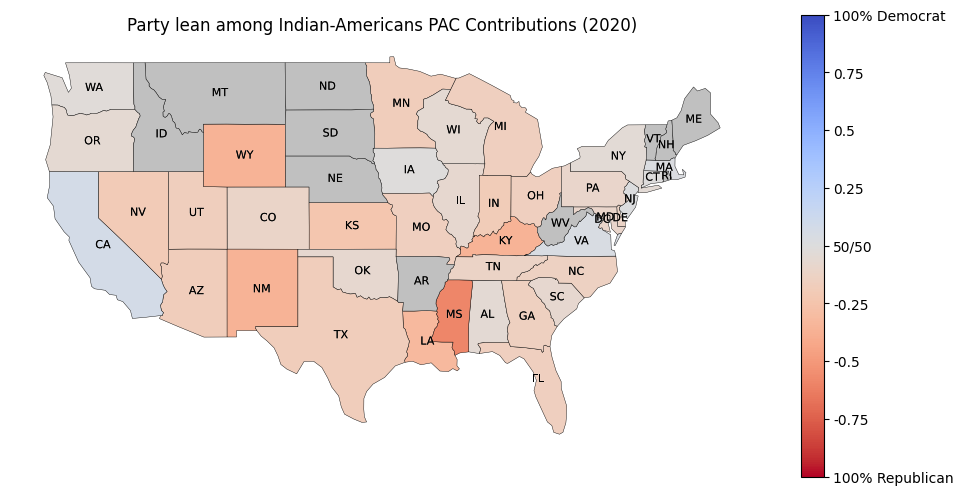

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df = state_pac_df.copy()
copy_df.loc[copy_df['sum_indian'] < 100000, 'dollar_lean_indian'] = np.nan

map = copy_df.plot(
    column="dollar_lean_indian",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "silver"},
    vmin=-1,
    vmax=1
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = ["100% Democrat" if tick == 1 
               else "100% Republican" if tick == -1 
               else "50/50" if tick == 0
               else tick for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among Indian-Americans PAC Contributions (20{year})')
ax.axis("off")
plt.show()

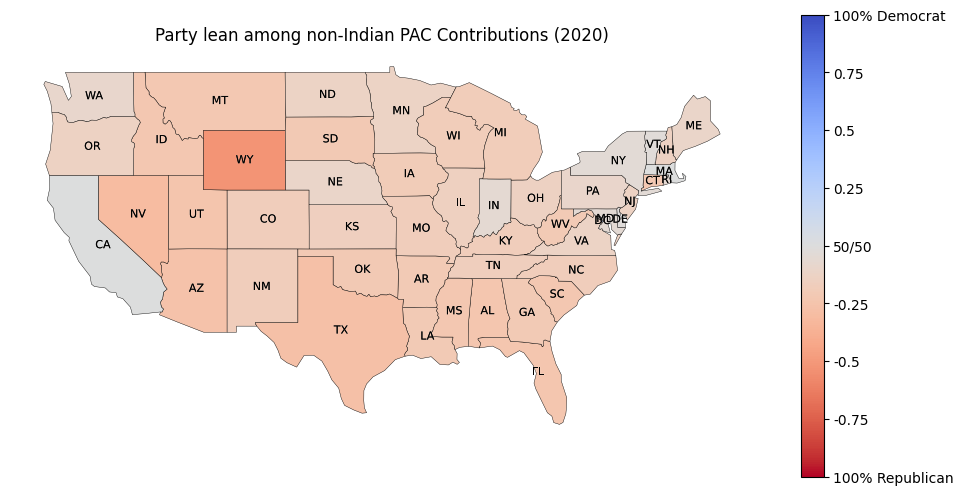

In [38]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df = state_pac_df.copy()
copy_df.loc[copy_df['sum_indian'] < 100000, 'dollar_lean_indian'] = np.nan

map = copy_df.plot(
    column="dollar_lean_other",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "silver"},
    vmin=-1,
    vmax=1
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = ["100% Democrat" if tick == 1 
               else "100% Republican" if tick == -1 
               else "50/50" if tick == 0
               else tick for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among non-Indian PAC Contributions (20{year})')
ax.axis("off")
plt.show()

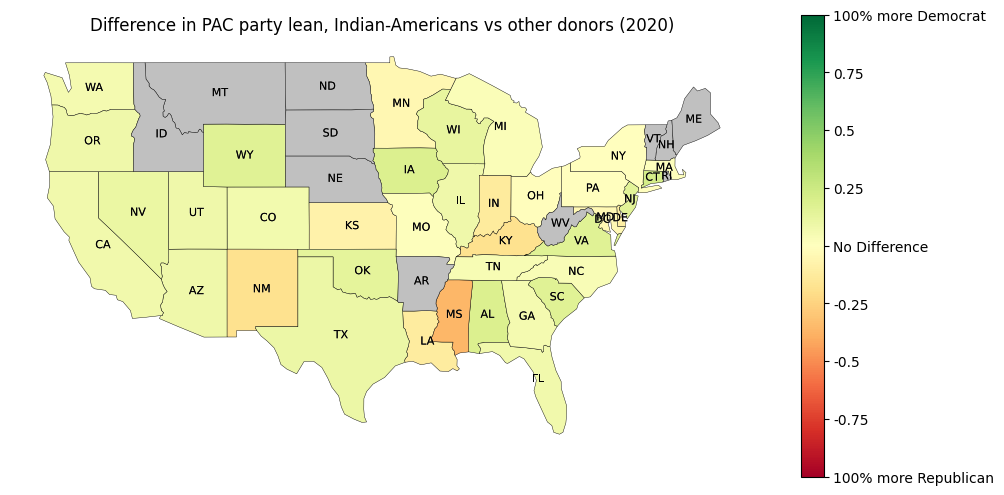

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df["dollar_lean_diff"] = copy_df["dollar_lean_indian"] - copy_df["dollar_lean_other"] 

map = copy_df.plot(
    column="dollar_lean_diff",
    cmap="RdYlGn",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "silver"},
    vmin=-1,
    vmax=1
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = ["100% more Democrat" if tick == 1 
               else "100% more Republican" if tick == -1 
               else "No Difference" if tick == 0
               else tick for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Difference in PAC party lean, Indian-Americans vs other donors (20{year})')
ax.axis("off")
plt.show()

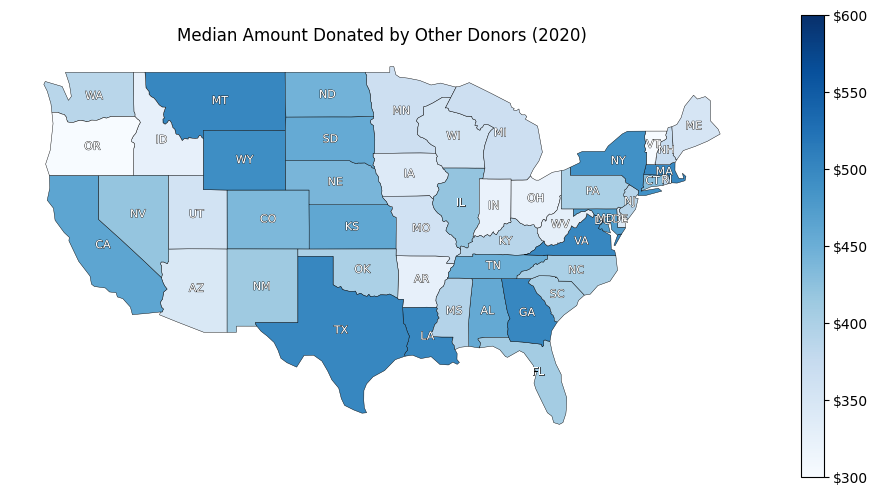

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
map = state_df.plot(
    column="med_other",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=600
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"${int(tick):,}" if tick != 5000 else "$5,000+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Median Amount Donated by Other Donors (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

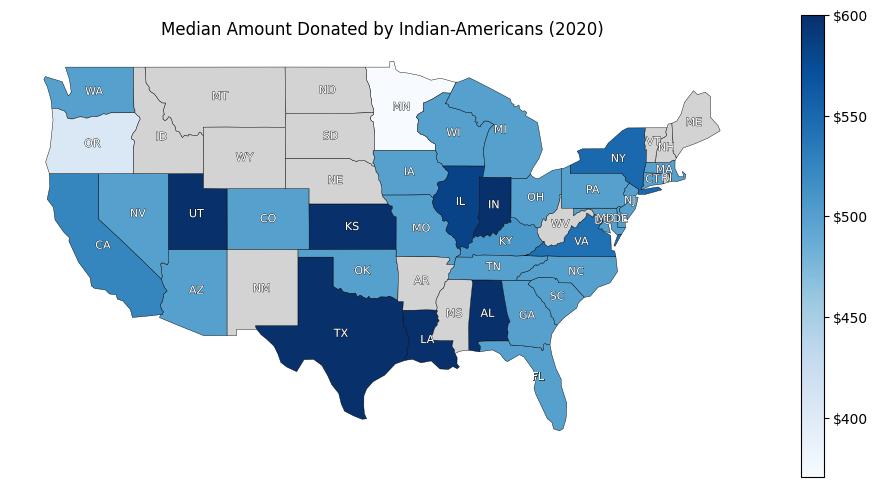

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df = state_df.copy()
copy_df.loc[copy_df['sum_indian'] < 250000, 'med_indian'] = np.nan

map = copy_df.plot(
    column="med_indian",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=600
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"${int(tick):,}" if tick != 5000 else "$5,000+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Median Amount Donated by Indian-Americans (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [ ]:
donors[(donors["cycle"] == 2020) & (donors["indian"] == True) & (donors["state"] == "IN")].iloc[:5]

,contrib_id,name_new,orgname,realcode,gender,occupation,city,state,total_donated,donation_count,avg_donation,med_donation,combined_ratio,indian,cycle,sector
11822567,U0000003736A,claire gagan,Retired,X1200,F,RETIRED,VALPARAISO,IN,50004.0,91,549.494505,250.0,20.900813,True,2020,NaN
11825493,b0608349608,bharat h barai,Premier Oncology Hematology Assoc,J7500,M,PHYSICIAN,MUNSTER,IN,43601.0,29,1503.482759,1000.0,36.992357,True,2020,Ideology/Single Issue
11828373,a00002496371,bharat barai,[24T Contribution],Z9500,M,MED DOCTOR,MUNSTER,IN,38581.0,28,1377.892857,1000.0,65.559332,True,2020,Party
11832996,i30039735121,rao polavarapu,Anthem Inc,H3700,M,IT ANALYST,RICHMOND,IN,32800.0,9,3644.444444,2800.0,15.292134,True,2020,Health
11837414,j1001839178,amish shah,Kem Krest,Y4000,M,PRESIDENT,BRISTOL,IN,28800.0,5,5760.000000,2800.0,6.228569,True,2020,Unknown


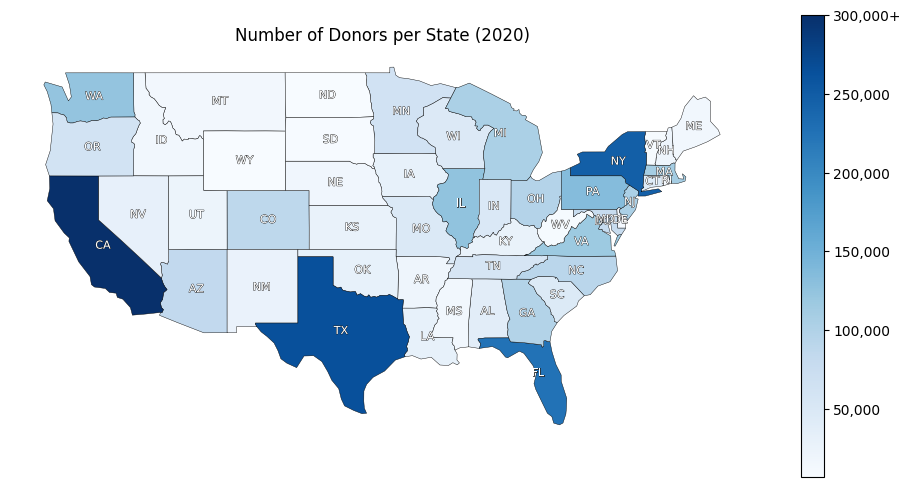

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df = state_df.copy()
copy_df["count_total"] = copy_df["count_other"] + copy_df["count_indian"]

map = copy_df.plot(
    column="count_total",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=300000
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"{int(tick):,}" if tick != 300000 else "300,000+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Number of Donors per State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

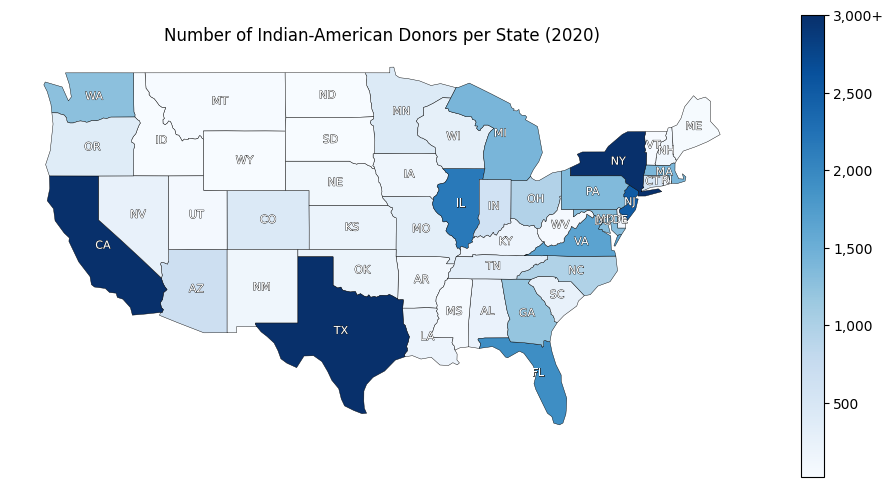

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

map = copy_df.plot(
    column="count_indian",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=3000
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"{int(tick):,}" if tick != 3000 else "3,000+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Number of Indian-American Donors per State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [ ]:
state_df[["state", "count_other", "count_indian", "Indian Pop"]].sort_values(by="count_indian", ascending=False).tail(10)

,state,count_other,count_indian,Indian Pop
11,UT,23300,87,12103
30,MS,16215,81,7060
40,WV,9950,61,3375
47,ME,16522,50,1844
26,VT,9868,39,1351
1,MT,15236,38,756
3,ID,16773,35,2948
19,SD,8398,30,1676
2,ND,6734,29,993
12,WY,7022,24,606


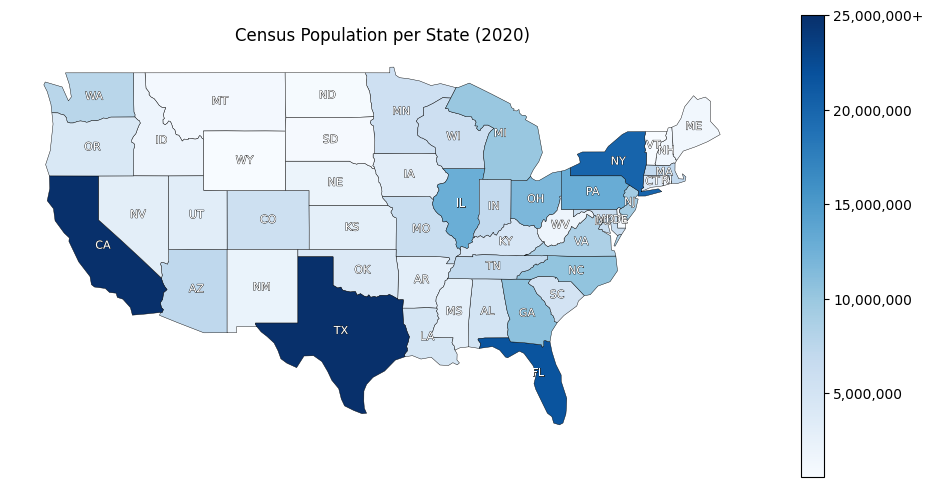

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

map = state_df.plot(
    column="Census Pop",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=25000000
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"{int(tick):,}" if tick != 25000000 else "25,000,000+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Census Population per State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

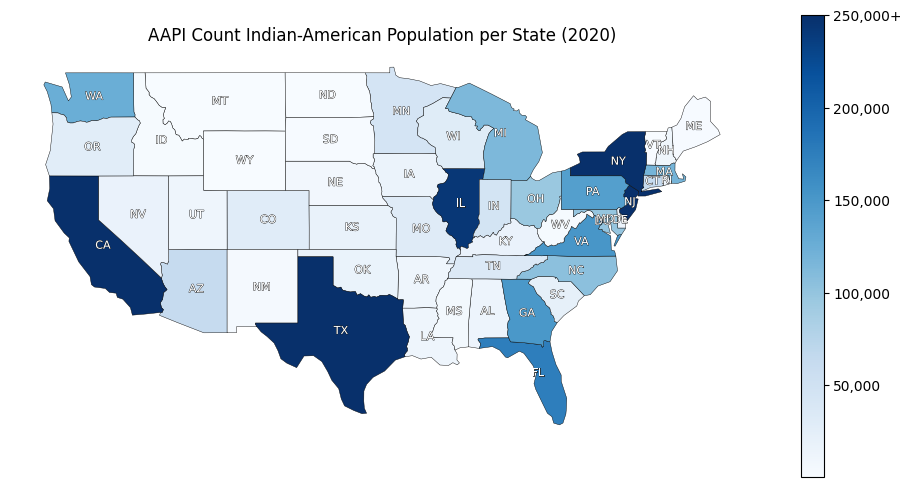

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

map = state_df.plot(
    column="Indian Pop",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=250000
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"{int(tick):,}" if tick != 250000 else "250,000+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"AAPI Count Indian-American Population per State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

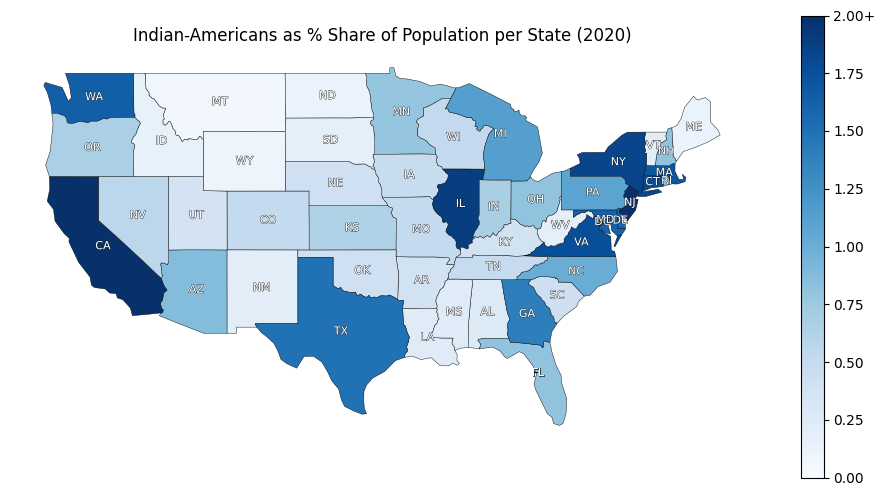

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

map = state_df.plot(
    column="Share",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=0,
    vmax=2
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"{tick:.2f}" if tick != 2 else "2.00+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Indian-Americans as % Share of Population per State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [ ]:
state_df["count_pc"] = (state_df["count_other"] + state_df["count_indian"]) / state_df["Census Pop"] * 100
state_df["count_pc_indian"] = state_df["count_indian"] / state_df["Indian Pop"] * 100
state_df["count_pc_diff"] = state_df["count_pc_indian"] - state_df["count_pc"]
state_df["sum_pc"] = (state_df["sum_other"] + state_df["sum_indian"]) / state_df["Census Pop"] * 100
state_df["sum_pc_indian"] = state_df["sum_indian"] / state_df["Indian Pop"] * 100
state_df["sum_pc_diff"] = state_df["sum_pc_indian"] - state_df["sum_pc"]

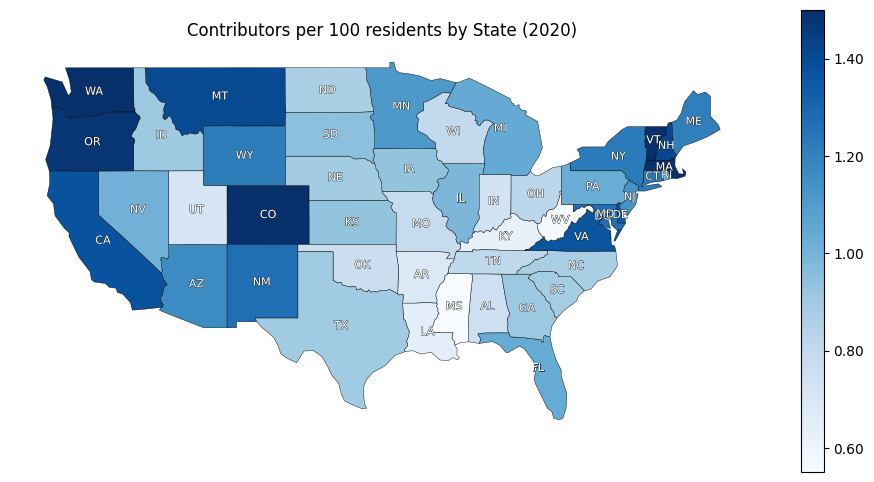

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

map = state_df.plot(
    column="count_pc",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=1.5
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
# round ticks to two decimal places
tick_labels = [f"{tick:.2f}" if tick != 1.5 else "1.50+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Contributors per 100 residents by State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

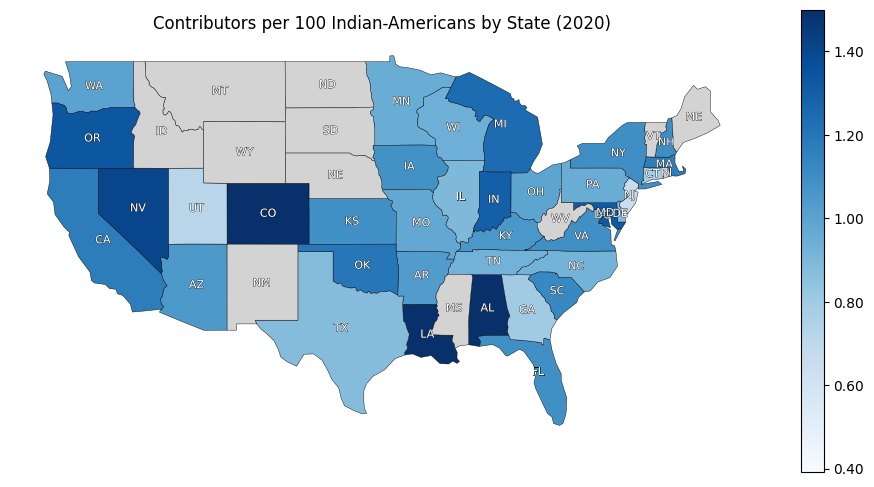

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df = state_df.copy()
copy_df.loc[copy_df['Indian Pop'] < 10000, 'count_pc_indian'] = np.nan

map = copy_df.plot(
    column="count_pc_indian",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=1.5
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
# round ticks to two decimal places
tick_labels = [f"{tick:.2f}" if tick != 1.5 else "1.50+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Contributors per 100 Indian-Americans by State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

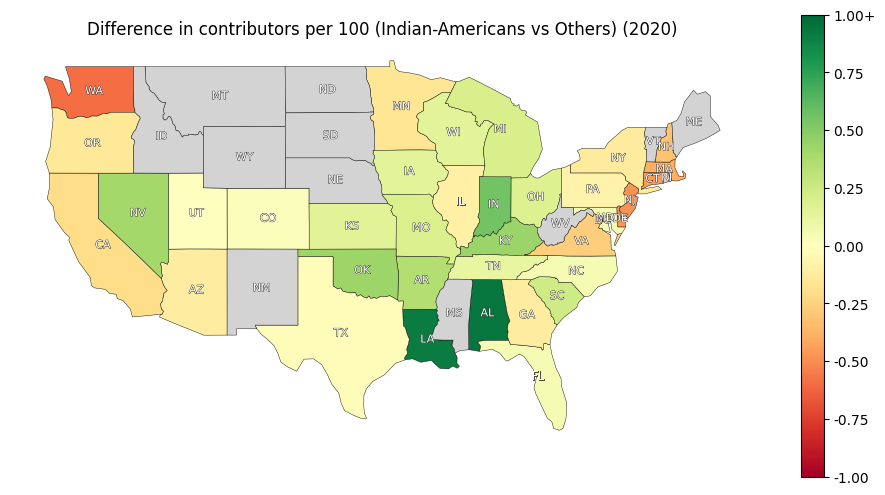

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df = state_df.copy()
copy_df.loc[copy_df['Indian Pop'] < 10000, 'count_pc_diff'] = np.nan

map = copy_df.plot(
    column="count_pc_diff",
    cmap="RdYlGn",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=-1,
    vmax=1
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"{tick:.2f}" if tick != 1 else "1.00+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Difference in contributors per 100 (Indian-Americans vs Others) (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

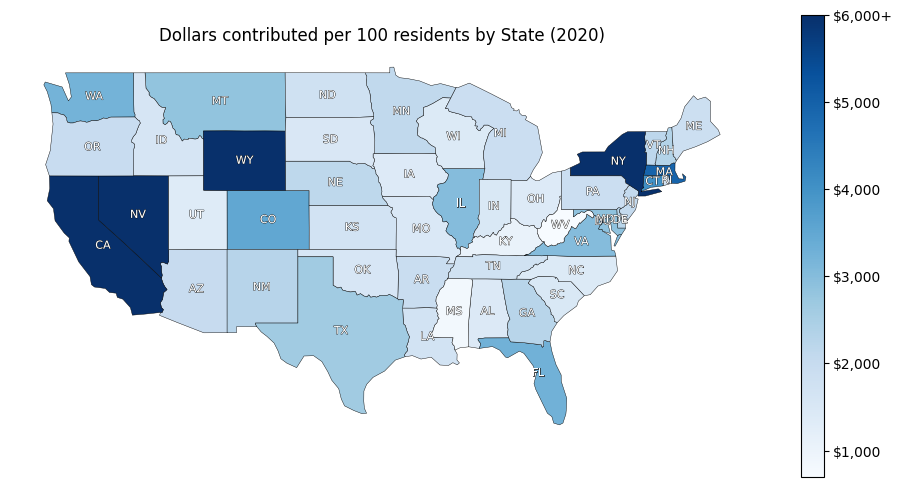

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

map = state_df.plot(
    column="sum_pc",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=6000
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"${int(tick):,}" if tick != 6000 else "$6,000+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Dollars contributed per 100 residents by State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

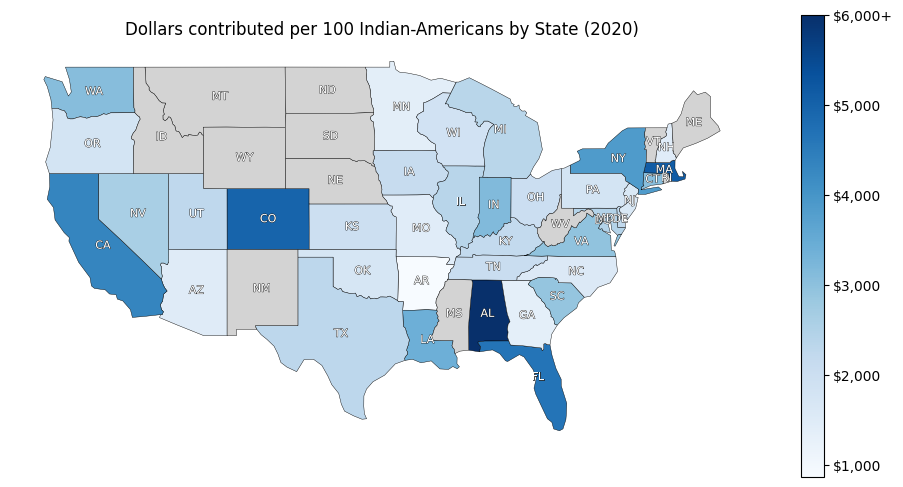

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df = state_df.copy()
copy_df.loc[copy_df['Indian Pop'] < 10000, 'sum_pc_indian'] = np.nan

map = copy_df.plot(
    column="sum_pc_indian",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=6000
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"${int(tick):,}" if tick != 6000 else "$6,000+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Dollars contributed per 100 Indian-Americans by State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

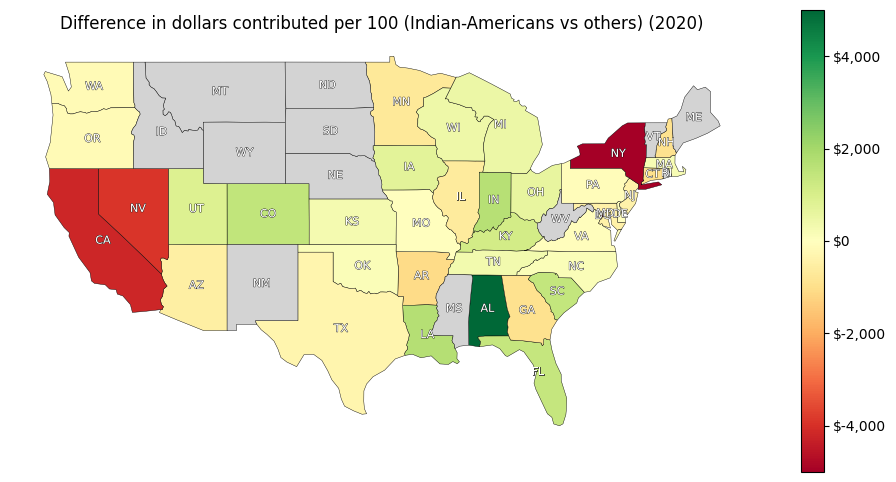

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

copy_df = state_df.copy()
copy_df.loc[copy_df['Indian Pop'] < 10000, 'sum_pc_diff'] = np.nan

map = copy_df.plot(
    column="sum_pc_diff",
    cmap="RdYlGn",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=-5000,
    vmax=5000
)

cbar = map.get_figure().get_axes()[1]
ticks = cbar.get_yticks()
tick_labels = [f"${int(tick):,}" if tick != 6000 else "$6,000+" for tick in ticks]
cbar.set_yticklabels(tick_labels)

for idx, row in state_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Difference in dollars contributed per 100 (Indian-Americans vs others) (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [ ]:
'''fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

map1 = state_df.plot(
    column="mean_other",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=5000
)

map2 = state_df.plot(
    column="mean_indian",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=5000
)

for map in [map1, map2]:
    cbar = map.get_figure().get_axes()[1]
    ticks = cbar.get_yticks()
    tick_labels = [f"${int(tick):,}" if tick != 5000 else "$5,000+" for tick in ticks]
    cbar.set_yticklabels(tick_labels)

for ax in [ax1, ax2]:
    for idx, row in state_df.iterrows():
        centroid = row["geometry"].centroid
        text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, 
                        ha="center", va="center", color="white")
        text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), 
                                path_effects.Normal()])

plt.suptitle(f"Mean Amount Donated by State (20{year})", fontsize=16)
ax1.set_title(f"Other Donors")
ax2.set_title(f"Indian-Americans")
ax.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")

plt.tight_layout()
plt.show()'''

In [ ]:
state_sector_stats = (
    donors[donors["cycle"] == 2000 + int(year)].groupby(["state", "sector"])
    .agg(
        total_donations=("total_donated", "sum"),
        mean_other=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == False].mean()),
        mean_indian=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == True].mean()),
        med_other=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == False].median()),
        med_indian=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == True].median()),
        sum_other=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == False].sum()),
        sum_indian=("total_donated", lambda x: x[donors.loc[x.index, "indian"] == True].sum()),
        count_other=("indian", lambda x: (x == False).sum()),
        count_indian=("indian", lambda x: (x == True).sum())
    )
    .sort_values("total_donations", ascending=False)
    .reset_index()
)
state_sector_stats.head(10)

,state,sector,total_donations,mean_other,mean_indian,med_other,med_indian,sum_other,sum_indian,count_other,count_indian
0,CA,Unknown,1.390132e+09,13589.095613,1718.410930,250.0,500.0,1.386862e+09,3270136.0,102057,1903
1,NY,Party,1.329065e+09,38191.183253,3957.552239,1000.0,1000.0,1.325883e+09,3181872.0,34717,804
2,CA,Party,7.317845e+08,9398.008630,3210.693667,1000.0,1000.0,7.252443e+08,6540183.0,77170,2037
3,NY,Finance,3.012514e+08,13952.015721,9960.516461,990.0,1000.0,2.964106e+08,4840811.0,21245,486
4,CA,Finance,3.009269e+08,10110.314514,18984.521531,550.0,935.0,2.890236e+08,11903295.0,28587,627
5,CA,Tech,2.205425e+08,7023.479929,2201.755369,500.0,500.0,2.181844e+08,2358080.0,31065,1071
6,FL,Finance,1.431596e+08,10143.411005,2633.081818,500.0,500.0,1.428699e+08,289639.0,14085,110
7,TX,Party,1.430613e+08,4390.243667,3342.906716,1000.0,1000.0,1.403737e+08,2687697.0,31974,804
8,CA,Ideology/Single Issue,1.410334e+08,2105.201351,1805.189723,319.0,336.0,1.396633e+08,1370139.0,66342,759
9,CA,Health,1.233845e+08,2763.379266,4340.752423,350.0,500.0,1.184578e+08,4926754.0,42867,1135


In [ ]:
# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
state_sector_df = gdf.merge(state_sector_stats, on="state", how="left")
state_sector_df = state_sector_df.merge(population[population["Year"] == 2020], left_on="state", right_on="Code", how="left")
state_sector_df.iloc[:2]

,iso_3166_2,name,geometry,state,sector,total_donations,mean_other,mean_indian,med_other,med_indian,sum_other,sum_indian,count_other,count_indian,Year,Name,Code,Indian Pop,Census Pop,Share
0,US-MN,Minnesota,"POLYGON ((-89.95766 47.28691, -90.13175 47.292...",MN,Party,24374414.0,3187.550776,1718.710843,1000.0,900.0,24231761.0,142653.0,7602,83,2020,Minnesota,MN,45092,5710735,0.789601
1,US-MN,Minnesota,"POLYGON ((-89.95766 47.28691, -90.13175 47.292...",MN,Finance,15994773.0,4262.374933,1215.297297,500.0,250.0,15949807.0,44966.0,3742,37,2020,Minnesota,MN,45092,5710735,0.789601


In [ ]:
sum_highest_other = state_sector_df[~state_sector_df["sector"].isin(["Unknown", "Party", "Other", "Ideology/Single Issue"])].sort_values(by="sum_other", ascending=False).drop_duplicates(subset='state', keep='first')
sum_highest_indian = state_sector_df[~state_sector_df["sector"].isin(["Unknown", "Party", "Other", "Ideology/Single Issue"])].sort_values(by="sum_indian", ascending=False).drop_duplicates(subset='state', keep='first')
count_highest_other = state_sector_df[~state_sector_df["sector"].isin(["Unknown", "Party", "Other", "Ideology/Single Issue"])].sort_values(by="count_other", ascending=False).drop_duplicates(subset='state', keep='first')
count_highest_indian = state_sector_df[~state_sector_df["sector"].isin(["Unknown", "Party", "Other", "Ideology/Single Issue"])].sort_values(by="count_indian", ascending=False).drop_duplicates(subset='state', keep='first')

In [ ]:
color_map = dict(zip(sum_highest_other["sector"], plt.cm.Set3(np.linspace(0, 1, len(sum_highest_other["sector"])))))
color_map["Tech"] = np.array([0.6, 0.5, 0.8, 1])
color_map["Defense"] = np.array([0.55, 0.75, 0.8, 1])
color_map["Health"] = np.array([0.8, 0.5, 0.8, 1])
color_map["Finance"] = np.array([0.6, 0.8, 0.6, 1])
color_map["Agribusiness"] = np.array([0.8, 0.8, 0.4, 1])
color_map["Law"] = np.array([0.55, 0.75, 0.9, 1])
color_map["Transportation"] = np.array([0.9, 0.7, 0.1, 1])
color_map["Manufacturing"] = np.array([1.0, 0.5, 0.5, 1])
color_map["Energy"] = np.array([0.7, 0.87, 0.41, 1])
color_map["Labor"] = np.array([0.5, 0.8, 0.9, 1])
color_map["Construction"] = np.array([0.8, 0.8, 0.8, 1])

In [ ]:
color_map

{'Finance': array([0.6, 0.8, 0.6, 1. ]),
 'Health': array([0.8, 0.5, 0.8, 1. ]),
 'Law': array([0.55, 0.75, 0.9 , 1.  ]),
 'Energy': array([0.7 , 0.87, 0.41, 1.  ]),
 'Transportation': array([0.9, 0.7, 0.1, 1. ]),
 'Tech': array([0.6, 0.5, 0.8, 1. ]),
 'Manufacturing': array([1. , 0.5, 0.5, 1. ]),
 'Defense': array([0.55, 0.75, 0.8 , 1.  ]),
 'Agribusiness': array([0.8, 0.8, 0.4, 1. ]),
 'Labor': array([0.5, 0.8, 0.9, 1. ]),
 'Construction': array([0.8, 0.8, 0.8, 1. ])}

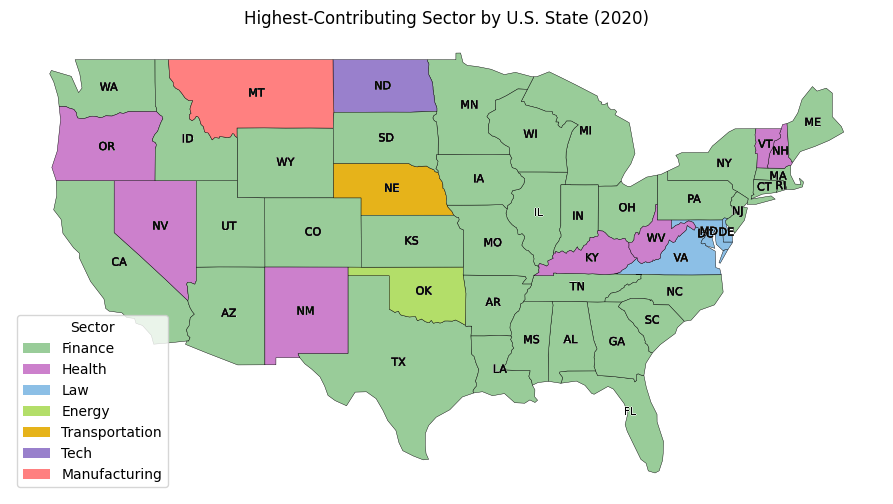

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

sum_highest_other.plot(
    column="sector",
    color=[color_map[s] for s in sum_highest_other['sector']],
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
)

legend_elements = [Patch(facecolor=color_map[s], label=s) for s in sum_highest_other["sector"].unique()]
ax.legend(handles=legend_elements, title='Sector')

for idx, row in state_sector_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

plt.title(f"Highest-Contributing Sector by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

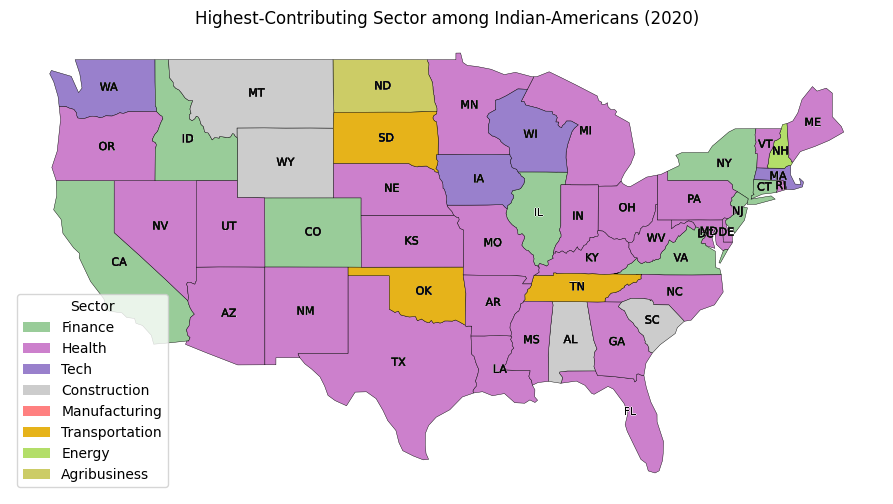

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

sum_highest_indian.plot(
    column="sector",
    color=[color_map[s] for s in sum_highest_indian['sector']],
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
)

legend_elements = [Patch(facecolor=color_map[s], label=s) for s in sum_highest_indian["sector"].unique()]
ax.legend(handles=legend_elements, title='Sector')

for idx, row in state_sector_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

plt.title(f"Highest-Contributing Sector among Indian-Americans (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

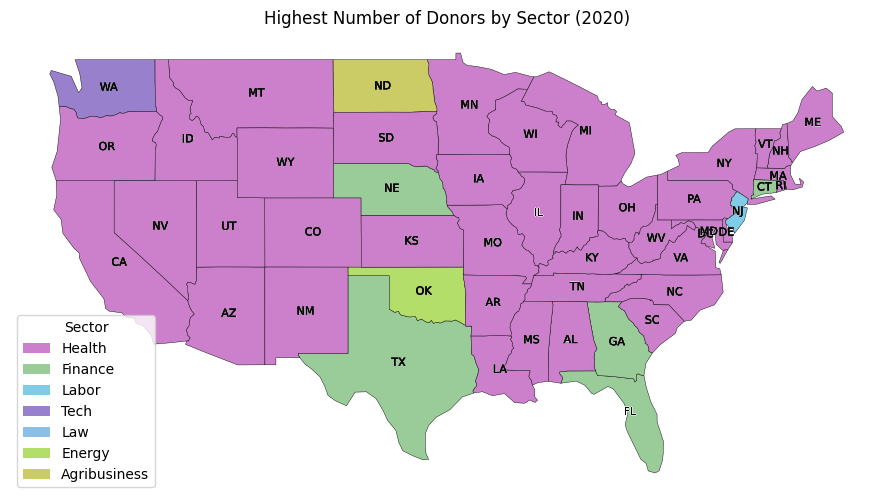

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

count_highest_other.plot(
    column="sector",
    color=[color_map[s] for s in count_highest_other['sector']],
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
)

legend_elements = [Patch(facecolor=color_map[s], label=s) for s in count_highest_other["sector"].unique()]
ax.legend(handles=legend_elements, title='Sector')

for idx, row in state_sector_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

plt.title(f"Highest Number of Donors by Sector (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

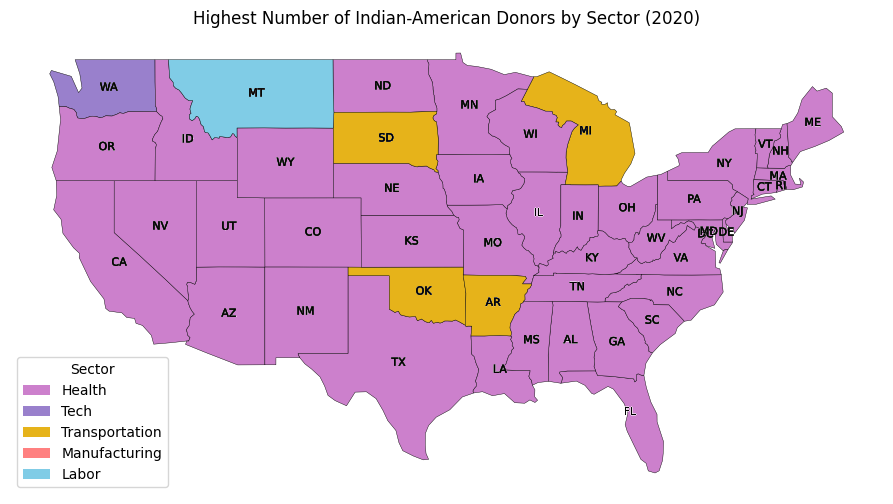

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

count_highest_indian.plot(
    column="sector",
    color=[color_map[s] for s in count_highest_indian['sector']],
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
)

legend_elements = [Patch(facecolor=color_map[s], label=s) for s in count_highest_indian["sector"].unique()]
ax.legend(handles=legend_elements, title='Sector')

for idx, row in state_sector_df.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

plt.title(f"Highest Number of Indian-American Donors by Sector (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()